# Aggregate 2026 Forecast: Bottom-Up Category Aggregation

Generate 2026 forecasts by aggregating category-level predictions.

**Objectives**:
1. Generate 2026 forecasts for each category using best scenario
2. Compare bottom-up (category aggregation) vs top-down (aggregate forecast)
3. Sensitivity analysis: which categories drive uncertainty?
4. Final deliverable: 2026 forecast with confidence intervals

## 0. Setup

In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.timeseries import TimeSeriesDataFrame
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode

In [2]:
# Chart style settings
import matplotlib.style as style
style.use({
    'font.family': 'Monospace',
    'font.size': 10,
})

In [3]:
# Data folders
processed_data_dir = Path.cwd().parent / "data" / "processed"
output_figures_dir = Path.cwd().parent / "outputs" / "figures"
output_figures_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Constants
FORECAST_START = pd.Timestamp('2025-08-31')  # First forecast month
FORECAST_END = pd.Timestamp('2026-12-31')    # End of 2026
CATEGORIES = [
    'food_stores',
    'clothing_footwear',
    'household_goods',
    'non_specialised',
    'other_stores',
    'non_store_retail'
]

### TabPFN Client Setup

In [5]:
import tabpfn_client
import dotenv
import os

# Load API key from .env
if os.getenv("PRIORLABS_API_KEY") is None:
    raise ValueError("Please set the PRIORLABS_API_KEY in the .env file")

dotenv.load_dotenv()
token = dotenv.get_key(dotenv.find_dotenv(), "PRIORLABS_API_KEY")
tabpfn_client.set_access_token(token)

print("✅ TabPFN client initialized")

✅ TabPFN client initialized


### Load Data

In [6]:
def load_category_sales_weights():
    """
    Load total retail sales values and calculate weights based on TOTAL retail (not just internet).

    Calculates total retail sales from:
    - Internet sales (£m/week) from IntValSA sheet
    - Internet as % of total from ISCPNSA3 sheet  
    - Total retail = Internet sales / (Internet % / 100)

    Returns
    -------
    df_weights : pd.DataFrame
        Time-varying weights for each category (indexed by date)
    weights_avg : dict
        Average weights across entire period (for weighted aggregation)
    """
    import re

    # Read both sheets
    raw_data_dir = Path.cwd().parent / "data" / "raw"
    xlsx_file = raw_data_dir / 'internetreferencetables.xlsx'

    # Internet sales VALUES (£m/week)
    df_val_raw = pd.read_excel(xlsx_file, sheet_name='IntValSA', skiprows=5)
    df_val_raw = df_val_raw.rename(columns={df_val_raw.columns[0]: 'date'})

    # Internet sales PERCENTAGES (% of total retail)
    df_pct_raw = pd.read_excel(xlsx_file, sheet_name='ISCPNSA3', skiprows=5)
    df_pct_raw = df_pct_raw.rename(columns={df_pct_raw.columns[0]: 'date'})

    # Filter valid dates (YYYY MMM format)
    date_pattern = r'^\d{4}\s[A-Z][a-z]{2}$'
    valid_dates_val = df_val_raw['date'].astype(str).str.match(date_pattern)
    valid_dates_pct = df_pct_raw['date'].astype(str).str.match(date_pattern)

    df_val = df_val_raw[valid_dates_val].copy()
    df_pct = df_pct_raw[valid_dates_pct].copy()

    # Parse dates to month-end
    df_val['date'] = pd.to_datetime(df_val['date'], format='%Y %b')
    df_val['date'] = df_val['date'] + pd.offsets.MonthEnd(0)

    df_pct['date'] = pd.to_datetime(df_pct['date'], format='%Y %b')
    df_pct['date'] = df_pct['date'] + pd.offsets.MonthEnd(0)

    # Merge both datasets on date
    df_merged = df_val.merge(df_pct, on='date', suffixes=('_val', '_pct'))

    # Filter to analysis period (2015-2025)
    df_merged = df_merged[(df_merged['date'] >= '2015-01-31') & (df_merged['date'] <= '2025-07-31')]
    df_merged = df_merged.set_index('date')

    # Category column positions in merged dataframe
    # After merge: columns 0-7 are from df_val, columns 8-15 are from df_pct
    # Column 0 = All retail, 1 = Food, 2 = Non-food total, 3 = Non-specialised,
    # 4 = Clothing, 5 = Household, 6 = Other, 7 = Non-store
    categories_map = {
        'food_stores': (1, 9),       # (val_col, pct_col)
        'clothing_footwear': (4, 12),
        'household_goods': (5, 13),
        'non_specialised': (3, 11),
        'other_stores': (6, 14),
        'non_store_retail': (7, 15)
    }

    categories = list(categories_map.keys())

    # Calculate TOTAL retail sales for each category
    # Total retail = Internet sales (£m) / (Internet % / 100)
    df_total_retail = pd.DataFrame(index=df_merged.index)

    for cat, (val_col, pct_col) in categories_map.items():
        internet_val = pd.to_numeric(df_merged.iloc[:, val_col], errors='coerce')
        internet_pct = pd.to_numeric(df_merged.iloc[:, pct_col], errors='coerce')

        # Calculate total retail sales
        df_total_retail[cat] = internet_val / (internet_pct / 100)

    # Calculate weights: each category's total retail as proportion of sum
    df_total_retail['total_6cat'] = df_total_retail[categories].sum(axis=1)

    df_weights = pd.DataFrame(index=df_total_retail.index)
    for cat in categories:
        df_weights[cat] = df_total_retail[cat] / df_total_retail['total_6cat']

    # Calculate average weights across entire period
    weights_avg = {cat: df_weights[cat].mean() for cat in categories}

    return df_weights, weights_avg

In [7]:
# Load category data with regime dummies
df_categories = pd.read_pickle(processed_data_dir / "category_data_with_regimes.pkl")

# Load forecast summary from notebook 06
forecast_summary = pd.read_csv(processed_data_dir / "category_forecast_summary.csv")

# Load sales weights from IntValSA sheet
df_weights, weights_avg = load_category_sales_weights()

print(f"Category data shape: {df_categories.shape}")
print(f"Date range: {df_categories.index.min()} to {df_categories.index.max()}")
print(f"\nForecast summary from notebook 06:")
print(forecast_summary)
print(f"\n📊 Category Sales Weights (average 2015-2025):")
print("=" * 80)
print("Based on internet sales values (£m/week) from ONS IntValSA sheet")
print("-" * 80)
for cat in CATEGORIES:
    weight = weights_avg[cat]
    print(f"{cat:25s}: {weight * 100:5.1f}%")
print("-" * 80)
print(f"{'Total':25s}: {sum(weights_avg.values()) * 100:5.1f}%")

Category data shape: (127, 10)
Date range: 2015-01-31 00:00:00 to 2025-07-31 00:00:00

Forecast summary from notebook 06:
            Category  MAE Scenario A  MAE Scenario B  MAE Scenario C  \
0        Food Stores           4.228           1.184           0.381   
1  Clothing Footwear          12.743           5.358           1.542   
2    Household Goods          13.113           2.779           1.570   
3    Non Specialised           9.431           5.080           1.565   
4       Other Stores          12.657           2.494           3.474   
5   Non Store Retail          10.291           1.601           0.553   

  Best Scenario  Best MAE  
0             C     0.381  
1             C     1.542  
2             C     1.570  
3             C     1.565  
4             B     2.494  
5             C     0.553  

📊 Category Sales Weights (average 2015-2025):
Based on internet sales values (£m/week) from ONS IntValSA sheet
-----------------------------------------------------------------

## 1. Helper Functions

In [8]:
def prepare_category_tsdf_full_data(df, category):
    """
    Prepare TimeSeriesDataFrame for a category using ALL available data (no train/test split).

    Parameters
    ----------
    df : pd.DataFrame
        Category data with regime dummies (d_cov, d_post)
    category : str
        Category column name

    Returns
    -------
    train_tsdf : TimeSeriesDataFrame
        Full historical data for training
    """
    df_prep = df.reset_index()
    df_prep = df_prep.rename(columns={category: 'target'})
    if 'date' in df_prep.columns:
        df_prep = df_prep.rename(columns={'date': 'timestamp'})
    df_prep['item_id'] = category

    # Add calendar features
    df_prep['month'] = df_prep['timestamp'].dt.month
    df_prep['quarter'] = df_prep['timestamp'].dt.quarter

    # Select columns
    cols = ['item_id', 'timestamp', 'target', 'd_cov', 'd_post', 'month', 'quarter']
    df_prep = df_prep[cols]

    # Create TimeSeriesDataFrame
    train_tsdf = TimeSeriesDataFrame.from_data_frame(
        df_prep,
        id_column='item_id',
        timestamp_column='timestamp',
        static_features_df=None
    )

    return train_tsdf

In [9]:
def create_2026_forecast_tsdf(category, forecast_dates, scenario='C'):
    """
    Create forecast TimeSeriesDataFrame for 2026 with scenario-specific regime dummies.

    Parameters
    ----------
    category : str
        Category name
    forecast_dates : pd.DatetimeIndex
        Dates to forecast (2025-08 to 2026-12)
    scenario : str, {'A', 'B', 'C'}
        Scenario type

    Returns
    -------
    forecast_tsdf : TimeSeriesDataFrame
        Forecast data with NaN target and scenario-specific regime dummies
    """
    scenario_regimes = {
        'A': {'d_cov': 0, 'd_post': 0},  # Pre-COVID
        'B': {'d_cov': 1, 'd_post': 0},  # COVID
        'C': {'d_cov': 1, 'd_post': 1}   # Post-COVID
    }

    regimes = scenario_regimes[scenario]

    forecast_df = pd.DataFrame({
        'timestamp': forecast_dates,
        'item_id': category,
        'target': np.nan,
        'd_cov': regimes['d_cov'],
        'd_post': regimes['d_post'],
        'month': forecast_dates.month,
        'quarter': forecast_dates.quarter
    })

    forecast_tsdf = TimeSeriesDataFrame.from_data_frame(
        forecast_df,
        id_column='item_id',
        timestamp_column='timestamp',
        static_features_df=None
    )

    return forecast_tsdf

## 2. Generate 2026 Forecasts: Best Scenario per Category

In [10]:
# Generate forecast dates (Aug 2025 - Dec 2026)
forecast_dates = pd.date_range(start=FORECAST_START, end=FORECAST_END, freq='M')
print(f"Forecasting {len(forecast_dates)} months: {forecast_dates[0]} to {forecast_dates[-1]}")

Forecasting 17 months: 2025-08-31 00:00:00 to 2026-12-31 00:00:00


In [11]:
# Initialize predictor
predictor = TabPFNTimeSeriesPredictor(tabpfn_mode=TabPFNMode.CLIENT)

# Storage for forecasts
forecasts_2026 = {}

# Load best scenarios from forecast summary (dynamic, not hardcoded)
best_scenarios = {}
for _, row in forecast_summary.iterrows():
    # Map from "Food Stores" to "food_stores"
    category_name = row['Category'].lower().replace(' ', '_')
    best_scenarios[category_name] = row['Best Scenario']

print(f"Best scenarios loaded from forecast_summary.csv:")
for cat, scenario in best_scenarios.items():
    print(f"  {cat:25s} → Scenario {scenario}")

print("\nGenerating 2026 forecasts using best scenario per category...\n")

for category in CATEGORIES:
    scenario = best_scenarios[category]
    print(f"  {category:25s} → Scenario {scenario}", end=' ... ')

    # Prepare full historical data
    train_tsdf = prepare_category_tsdf_full_data(df_categories, category)

    # Create 2026 forecast input
    forecast_tsdf = create_2026_forecast_tsdf(category, forecast_dates, scenario=scenario)

    # Generate forecast
    pred = predictor.predict(train_tsdf, forecast_tsdf)

    # Store results
    forecasts_2026[category] = {
        'scenario': scenario,
        'predictions': pred,
        'train_tsdf': train_tsdf
    }

    # Show median forecast for 2026-12
    final_val = pred.loc[category, 0.5].iloc[-1]
    print(f"Dec 2026 forecast: {final_val:.1f}%")

print("\n✅ All category forecasts complete!")

Best scenarios loaded from forecast_summary.csv:
  food_stores               → Scenario C
  clothing_footwear         → Scenario C
  household_goods           → Scenario C
  non_specialised           → Scenario C
  other_stores              → Scenario B
  non_store_retail          → Scenario C

Generating 2026 forecasts using best scenario per category...

  food_stores               → Scenario C ... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 967.54it/s]
Processing: 100%|██████████| [00:01<00:00]


Dec 2026 forecast: 9.2%
  clothing_footwear         → Scenario C ... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1709.17it/s]
Processing: 100%|██████████| [00:01<00:00]


Dec 2026 forecast: 28.4%
  household_goods           → Scenario C ... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1673.70it/s]
Processing: 100%|██████████| [00:01<00:00]


Dec 2026 forecast: 26.5%
  non_specialised           → Scenario C ... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1736.77it/s]
Processing: 100%|██████████| [00:01<00:00]


Dec 2026 forecast: 25.9%
  other_stores              → Scenario B ... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1636.48it/s]
Processing: 100%|██████████| [00:01<00:00]


Dec 2026 forecast: 22.4%
  non_store_retail          → Scenario C ... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1541.46it/s]
Processing: 100%|██████████| [00:01<00:00]

Dec 2026 forecast: 90.3%

✅ All category forecasts complete!


## 3. Bottom-Up Aggregate: Volume-Weighted Approach

In [12]:
# Extract median forecasts for each category
forecast_medians = {}
forecast_q10 = {}
forecast_q90 = {}

for category in CATEGORIES:
    pred = forecasts_2026[category]['predictions']
    forecast_medians[category] = pred.loc[category, 0.5]
    forecast_q10[category] = pred.loc[category, 0.1]
    forecast_q90[category] = pred.loc[category, 0.9]

# Create DataFrame
df_forecast_medians = pd.DataFrame(forecast_medians)
df_forecast_q10 = pd.DataFrame(forecast_q10)
df_forecast_q90 = pd.DataFrame(forecast_q90)

print("Category forecasts (median, Dec 2026):")
print(df_forecast_medians.iloc[-1].sort_values(ascending=False).round(1))

Category forecasts (median, Dec 2026):
non_store_retail     90.3
clothing_footwear    28.4
household_goods      26.5
non_specialised      25.9
other_stores         22.4
food_stores           9.2
Name: 2026-12-31 00:00:00, dtype: float64


In [13]:
# Volume-weighted average using sales weights from IntValSA
# Each category weighted by its proportion of total internet retail sales

# Calculate weighted aggregates
aggregate_median = sum(df_forecast_medians[cat] * weights_avg[cat] for cat in CATEGORIES)
aggregate_q10 = sum(df_forecast_q10[cat] * weights_avg[cat] for cat in CATEGORIES)
aggregate_q90 = sum(df_forecast_q90[cat] * weights_avg[cat] for cat in CATEGORIES)

print("\n📊 BOTTOM-UP AGGREGATE FORECAST (Volume-Weighted)")
print("=" * 80)
print(f"Weighted by internet sales volume (£m/week) from ONS IntValSA")
print(f"\nDec 2026 forecast: {aggregate_median.iloc[-1]:.2f}%")
print(f"80% Confidence Interval: [{aggregate_q10.iloc[-1]:.2f}%, {aggregate_q90.iloc[-1]:.2f}%]")
print(f"\nForecast trajectory:")
print(f"  {aggregate_median.index[0].strftime('%b %Y')}: {aggregate_median.iloc[0]:.2f}%")
# Find Dec 2025 and Jun 2026 by date, not by position
dec_2025 = aggregate_median[aggregate_median.index == '2025-12-31']
jun_2026 = aggregate_median[aggregate_median.index == '2026-06-30']
if len(dec_2025) > 0:
    print(f"  Dec 2025: {dec_2025.iloc[0]:.2f}%")
if len(jun_2026) > 0:
    print(f"  Jun 2026: {jun_2026.iloc[0]:.2f}%")
print(f"  {aggregate_median.index[-1].strftime('%b %Y')}: {aggregate_median.iloc[-1]:.2f}%")

print(f"\n📌 Weights used (average 2015-2025):")
for cat in CATEGORIES:
    print(f"  {cat:25s}: {weights_avg[cat] * 100:5.1f}%")


📊 BOTTOM-UP AGGREGATE FORECAST (Volume-Weighted)
Weighted by internet sales volume (£m/week) from ONS IntValSA

Dec 2026 forecast: 26.15%
80% Confidence Interval: [24.22%, 29.62%]

Forecast trajectory:
  Aug 2025: 24.84%
  Dec 2025: 26.15%
  Jun 2026: 24.96%
  Dec 2026: 26.15%

📌 Weights used (average 2015-2025):
  food_stores              :  43.1%
  clothing_footwear        :  11.7%
  household_goods          :   8.7%
  non_specialised          :   8.7%
  other_stores             :  14.1%
  non_store_retail         :  12.3%


## 4. Top-Down Aggregate Forecast (for comparison)

In [14]:
# Generate top-down forecast using aggregate data directly
aggregate_category = 'all_retail_ex_fuel'

print("Generating top-down forecast on aggregate data...")

# Prepare aggregate data
train_tsdf_agg = prepare_category_tsdf_full_data(df_categories, aggregate_category)

# Use Scenario C (post-COVID baseline) as this is the majority scenario
forecast_tsdf_agg = create_2026_forecast_tsdf(aggregate_category, forecast_dates, scenario='C')

# Generate forecast
pred_agg = predictor.predict(train_tsdf_agg, forecast_tsdf_agg)

# Extract quantiles
topdown_median = pred_agg.loc[aggregate_category, 0.5]
topdown_q10 = pred_agg.loc[aggregate_category, 0.1]
topdown_q90 = pred_agg.loc[aggregate_category, 0.9]

print(f"\n📊 TOP-DOWN AGGREGATE FORECAST (Scenario C)")
print("=" * 80)
print(f"Dec 2026 forecast: {topdown_median.iloc[-1]:.2f}%")
print(f"80% Confidence Interval: [{topdown_q10.iloc[-1]:.2f}%, {topdown_q90.iloc[-1]:.2f}%]")
print(f"\nForecast trajectory:")
print(f"  {topdown_median.index[0].strftime('%b %Y')}: {topdown_median.iloc[0]:.2f}%")
# Find Dec 2025 and Jun 2026 by date, not by position
dec_2025_td = topdown_median[topdown_median.index == '2025-12-31']
jun_2026_td = topdown_median[topdown_median.index == '2026-06-30']
if len(dec_2025_td) > 0:
    print(f"  Dec 2025: {dec_2025_td.iloc[0]:.2f}%")
if len(jun_2026_td) > 0:
    print(f"  Jun 2026: {jun_2026_td.iloc[0]:.2f}%")
print(f"  {topdown_median.index[-1].strftime('%b %Y')}: {topdown_median.iloc[-1]:.2f}%")

Generating top-down forecast on aggregate data...


Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1658.48it/s]
Processing: 100%|██████████| [00:01<00:00]


📊 TOP-DOWN AGGREGATE FORECAST (Scenario C)
Dec 2026 forecast: 28.39%
80% Confidence Interval: [26.45%, 31.31%]

Forecast trajectory:
  Aug 2025: 25.94%
  Dec 2025: 28.39%
  Jun 2026: 26.03%
  Dec 2026: 28.39%


## 5. Compare Bottom-Up vs Top-Down

In [15]:
# Compare Dec 2026 forecasts
comparison = pd.DataFrame({
    'Approach': ['Bottom-Up (Volume-Weighted)', 'Top-Down (Aggregate)'],
    'Dec 2026 Forecast': [aggregate_median.iloc[-1], topdown_median.iloc[-1]],
    'Lower 80%': [aggregate_q10.iloc[-1], topdown_q10.iloc[-1]],
    'Upper 80%': [aggregate_q90.iloc[-1], topdown_q90.iloc[-1]],
    'Interval Width': [
        aggregate_q90.iloc[-1] - aggregate_q10.iloc[-1],
        topdown_q90.iloc[-1] - topdown_q10.iloc[-1]
    ]
})

print("\n📊 BOTTOM-UP vs TOP-DOWN COMPARISON (Dec 2026)")
print("=" * 80)
print(comparison.round(2).to_string(index=False))

diff = aggregate_median.iloc[-1] - topdown_median.iloc[-1]
print(f"\nDifference: {diff:+.2f} percentage points")
print(f"Relative difference: {diff / topdown_median.iloc[-1] * 100:+.1f}%")
print(f"\nNote: Bottom-up uses volume-weighted average of category forecasts")


📊 BOTTOM-UP vs TOP-DOWN COMPARISON (Dec 2026)
                   Approach  Dec 2026 Forecast  Lower 80%  Upper 80%  Interval Width
Bottom-Up (Volume-Weighted)              26.15      24.22      29.62            5.40
       Top-Down (Aggregate)              28.39      26.45      31.31            4.86

Difference: -2.24 percentage points
Relative difference: -7.9%

Note: Bottom-up uses volume-weighted average of category forecasts


## 6. Visualization: 2026 Forecast Comparison

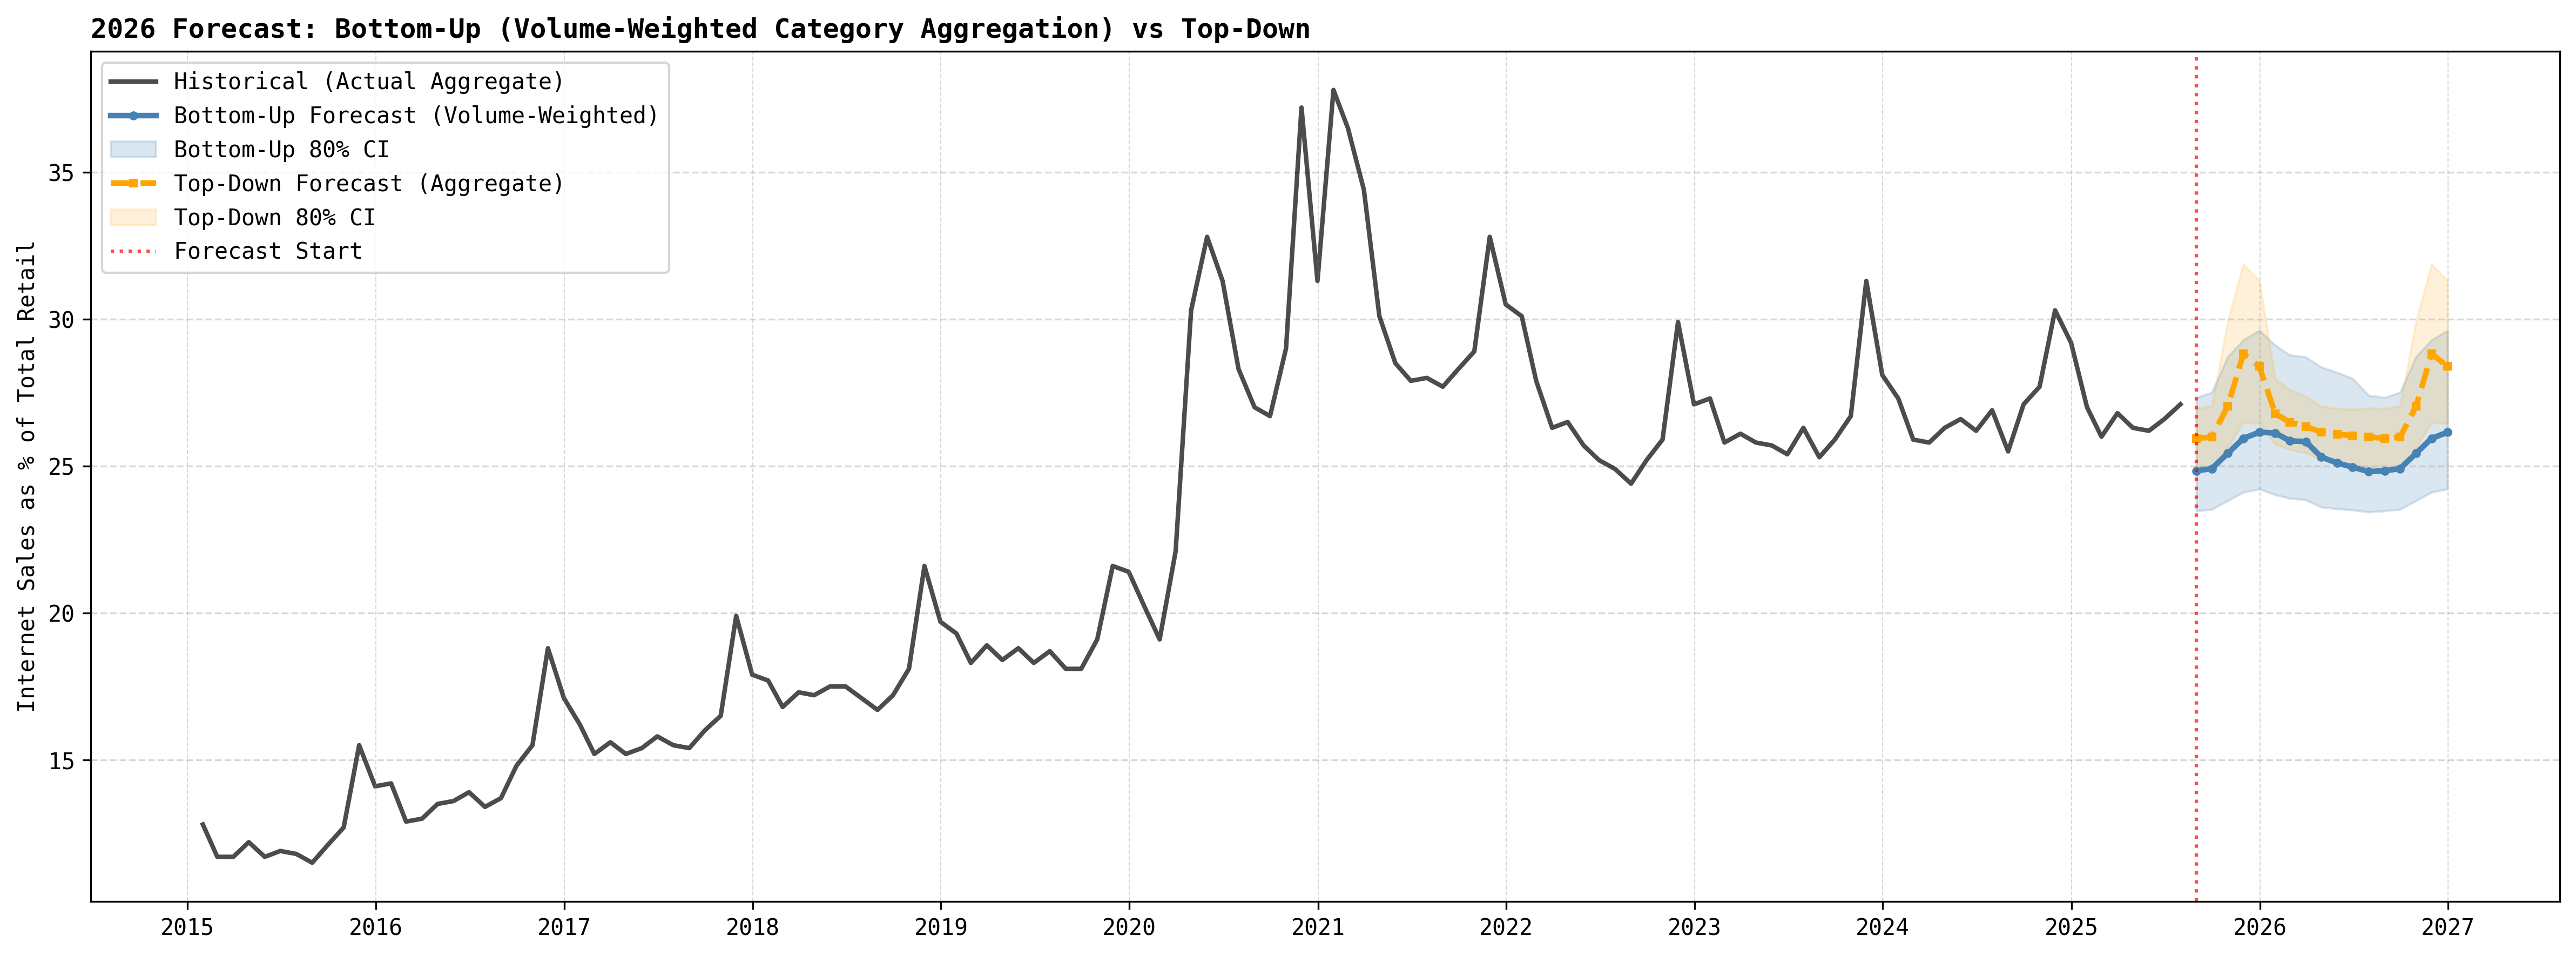

In [16]:
# Plot historical + forecasts (bottom-up vs top-down)
fig, ax = plt.subplots(figsize=(16, 6), dpi=300)

# Historical aggregate data
historical = df_categories['all_retail_ex_fuel']
ax.plot(historical.index, historical,
        color='black', linewidth=2, label='Historical (Actual Aggregate)', alpha=0.7)

# Bottom-up forecast (volume-weighted)
ax.plot(aggregate_median.index, aggregate_median,
        color='steelblue', linewidth=2.5, label='Bottom-Up Forecast (Volume-Weighted)', marker='o', markersize=3)
ax.fill_between(aggregate_median.index, aggregate_q10, aggregate_q90,
                color='steelblue', alpha=0.2, label='Bottom-Up 80% CI')

# Top-down forecast
ax.plot(topdown_median.index, topdown_median,
        color='orange', linewidth=2.5, label='Top-Down Forecast (Aggregate)',
        marker='s', markersize=3, linestyle='--')
ax.fill_between(topdown_median.index, topdown_q10, topdown_q90,
                color='orange', alpha=0.15, label='Top-Down 80% CI')

# Vertical line at forecast start
ax.axvline(FORECAST_START, color='red', linestyle=':', linewidth=1.5, alpha=0.7, label='Forecast Start')

# Formatting
time_range = pd.date_range(start='2015-01-01', end='2027-01-01', freq='YS')
ax.set_xticks(time_range)
ax.set_xticklabels([t.year for t in time_range])

for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

ax.legend(loc='upper left', fontsize=10)
ax.set_xlabel('')
ax.set_ylabel('Internet Sales as % of Total Retail')
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_title('2026 Forecast: Bottom-Up (Volume-Weighted Category Aggregation) vs Top-Down',
             loc='left', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(output_figures_dir / 'forecast_2026_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

## 7. Category Contribution Analysis

In [28]:
# Analyze which categories drive the bottom-up forecast
# Compare Jul 2025 (last actual) vs Dec 2026 (forecast)

jul_2025_actual = df_categories[CATEGORIES].iloc[-1]  # Last actual observation
dec_2026_forecast = df_forecast_medians.iloc[-1]  # Dec 2026 forecast

category_changes = pd.DataFrame({
    'Jul 2025 (Actual)': jul_2025_actual,
    'Dec 2026 (Forecast)': dec_2026_forecast,
    'Absolute Change': dec_2026_forecast - jul_2025_actual,
    'Relative Change (%)': (dec_2026_forecast - jul_2025_actual) / jul_2025_actual * 100,
    'Best Scenario': [best_scenarios[cat] for cat in CATEGORIES]
})

category_changes = category_changes.sort_values('Absolute Change', ascending=False)

print("\n📊 CATEGORY CONTRIBUTION TO 2026 FORECAST")
print("=" * 100)
print(category_changes.round(2))


📊 CATEGORY CONTRIBUTION TO 2026 FORECAST
                   Jul 2025 (Actual)  Dec 2026 (Forecast)  Absolute Change  \
household_goods                 22.6                26.48             3.88   
other_stores                    19.8                22.41             2.61   
clothing_footwear               26.0                28.39             2.39   
non_specialised                 23.9                25.93             2.03   
non_store_retail                88.7                90.28             1.58   
food_stores                      9.5                 9.17            -0.33   

                   Relative Change (%) Best Scenario  
household_goods                  17.16             C  
other_stores                     13.17             B  
clothing_footwear                 9.18             C  
non_specialised                   8.49             C  
non_store_retail                  1.78             C  
food_stores                      -3.43             C  


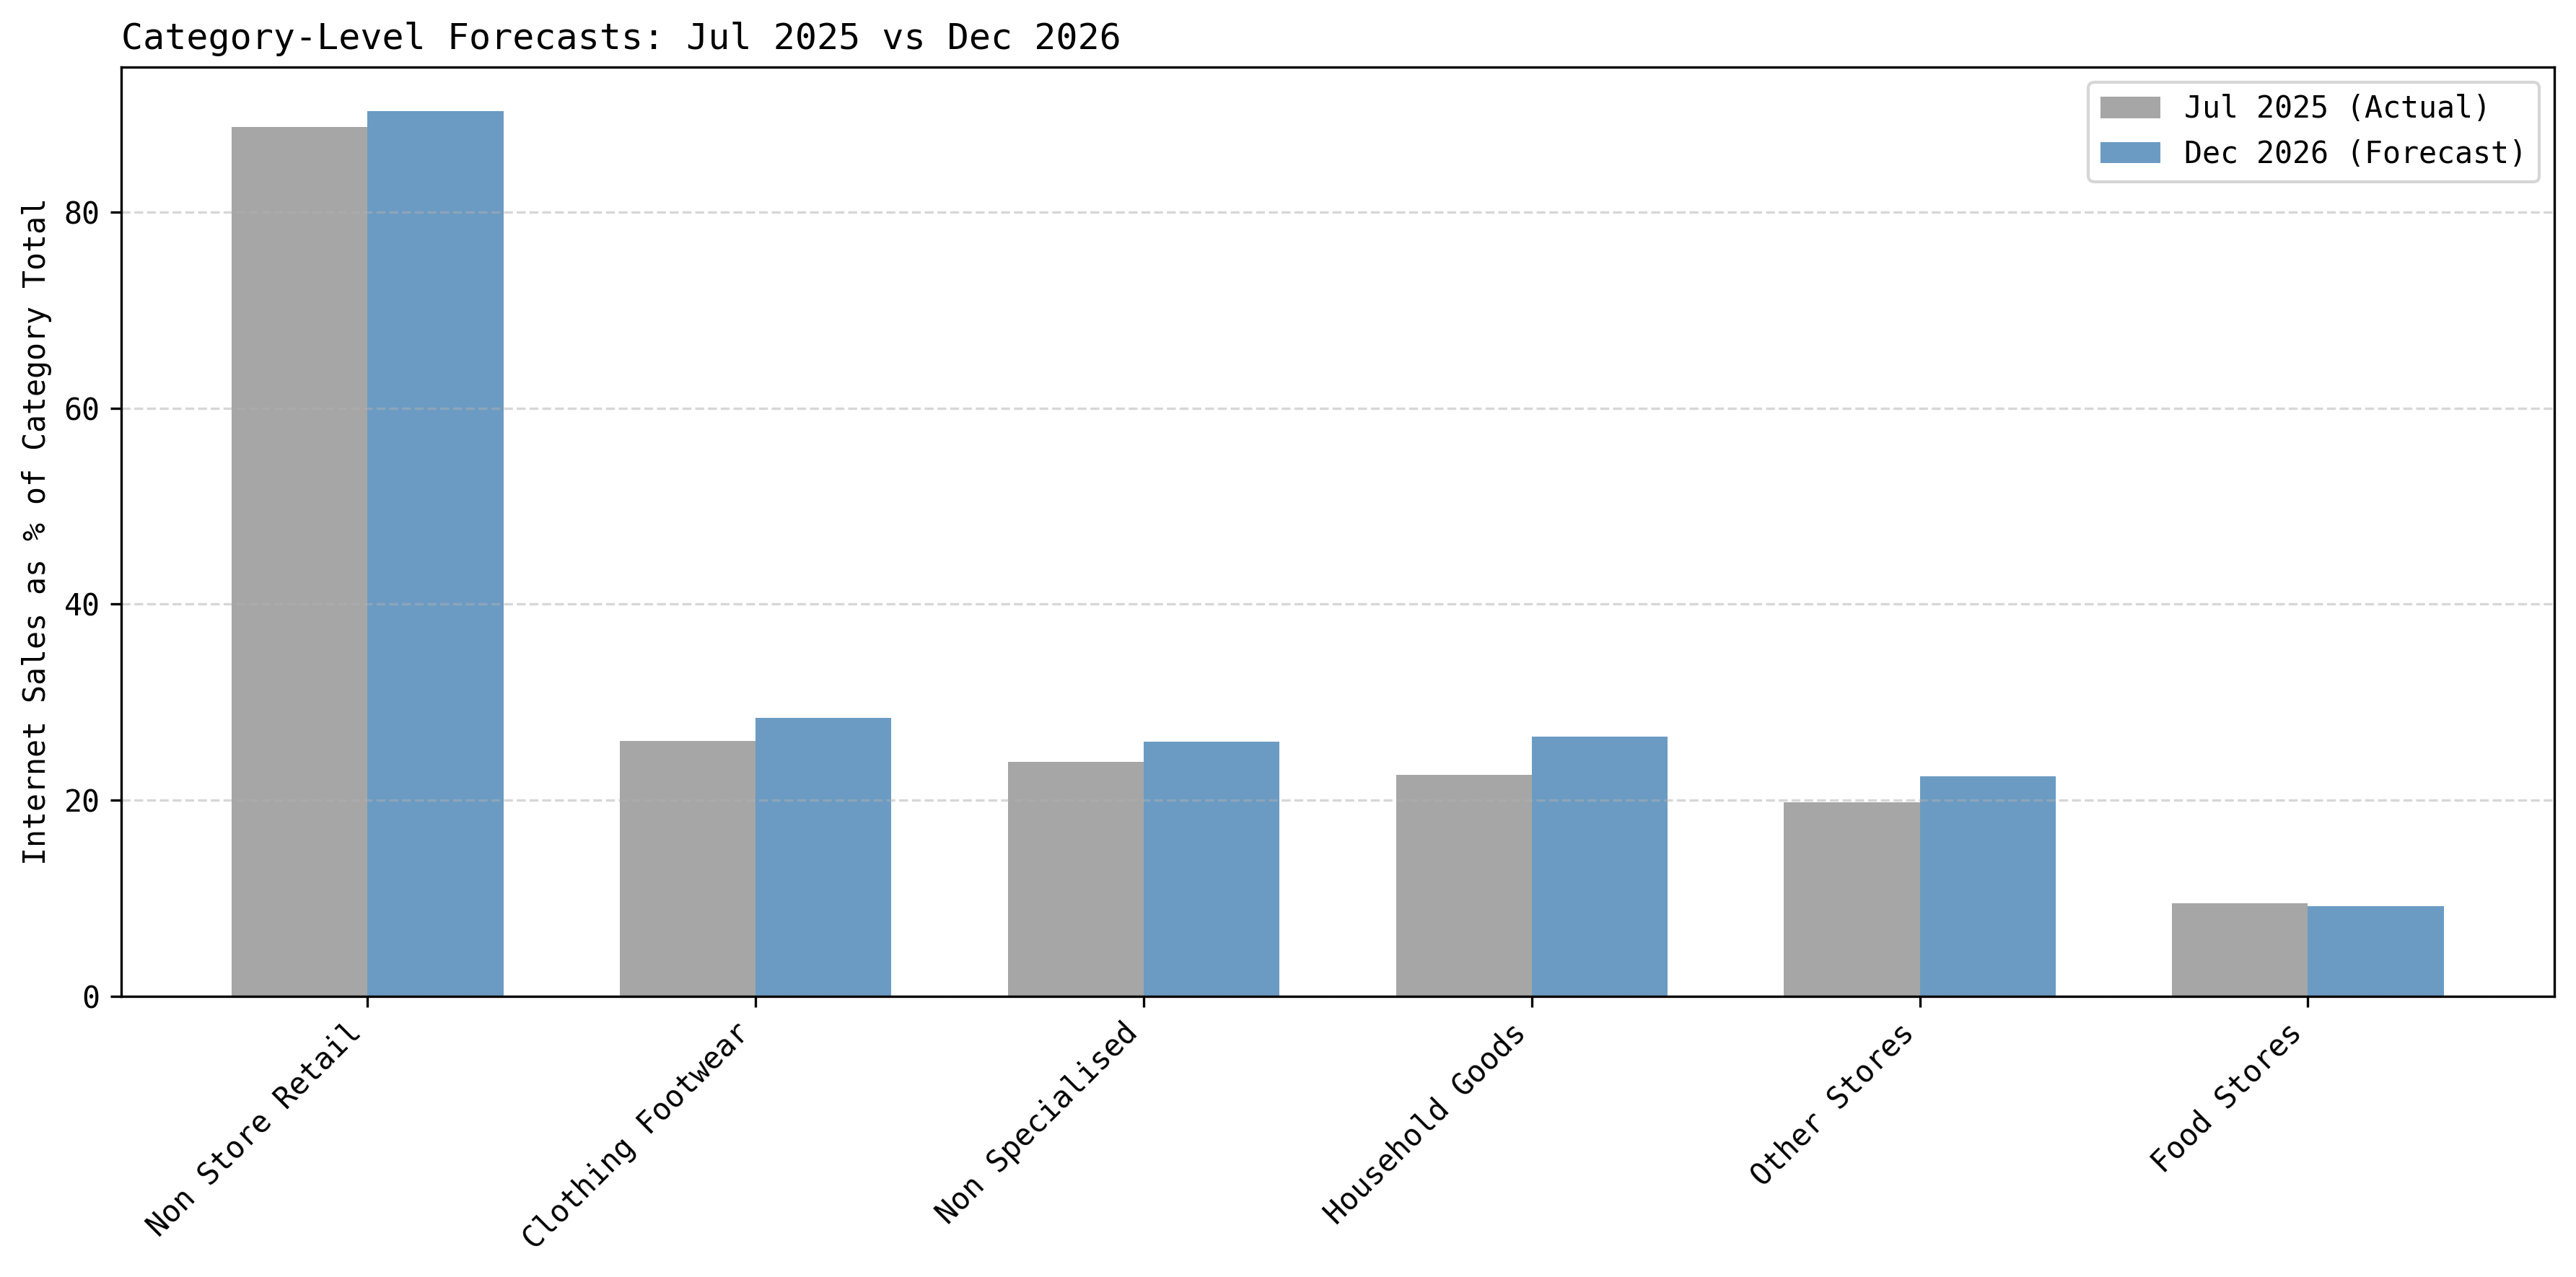

In [18]:
# Visualize category contributions
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

x = np.arange(len(CATEGORIES))
width = 0.35

# Sort by Jul 2025 actual value for better visualization
category_changes_sorted = category_changes.sort_values('Jul 2025 (Actual)', ascending=False)
categories_sorted = category_changes_sorted.index.tolist()

jul_vals = [category_changes_sorted.loc[cat, 'Jul 2025 (Actual)'] for cat in categories_sorted]
dec_vals = [category_changes_sorted.loc[cat, 'Dec 2026 (Forecast)'] for cat in categories_sorted]

ax.bar(x - width / 2, jul_vals, width, label='Jul 2025 (Actual)', color='gray', alpha=0.7)
ax.bar(x + width / 2, dec_vals, width, label='Dec 2026 (Forecast)', color='steelblue', alpha=0.8)

ax.set_ylabel('Internet Sales as % of Category Total')
ax.set_title('Category-Level Forecasts: Jul 2025 vs Dec 2026', loc='left', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels([cat.replace('_', ' ').title() for cat in categories_sorted], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(output_figures_dir / 'category_contributions_2026.png', bbox_inches='tight', dpi=300)
plt.show()

## 8. Sensitivity Analysis: Scenario Uncertainty

In [19]:
# What if ALL categories were Scenario A, B, or C?
# This shows the range of possible outcomes based on regime assumptions

print("Generating scenario sensitivity forecasts...")
print("(This generates up to 18 forecasts - may take 30-60 seconds)\n")

scenario_sensitivity = {}

for scenario in ['A', 'B', 'C']:
    print(f"Scenario {scenario}:")

    scenario_forecasts = {}

    for category in CATEGORIES:
        # Use existing forecast if it matches scenario, otherwise generate new one
        if forecasts_2026[category]['scenario'] == scenario:
            print(f"  {category:25s} - using cached forecast", end='')
            pred = forecasts_2026[category]['predictions']
        else:
            print(f"  {category:25s} - generating new forecast", end='')
            # Generate new forecast for this scenario
            train_tsdf = prepare_category_tsdf_full_data(df_categories, category)
            forecast_tsdf = create_2026_forecast_tsdf(category, forecast_dates, scenario=scenario)
            pred = predictor.predict(train_tsdf, forecast_tsdf)

        scenario_forecasts[category] = pred.loc[category, 0.5]
        print(" ✓")

    # Volume-weighted average across categories
    scenario_avg = sum(scenario_forecasts[cat] * weights_avg[cat] for cat in CATEGORIES)
    scenario_sensitivity[scenario] = scenario_avg

    print(f"  → Dec 2026 = {scenario_avg.iloc[-1]:.2f}%\n")

print("✅ Scenario sensitivity analysis complete!")

Generating scenario sensitivity forecasts...
(This generates up to 18 forecasts - may take 30-60 seconds)

Scenario A:
  food_stores               - generating new forecast

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 742.88it/s]
Processing: 100%|██████████| [00:01<00:00]


 ✓
  clothing_footwear         - generating new forecast

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1646.76it/s]
Processing: 100%|██████████| [00:01<00:00]


 ✓
  household_goods           - generating new forecast

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1491.57it/s]
Processing: 100%|██████████| [00:01<00:00]


 ✓
  non_specialised           - generating new forecast

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1530.77it/s]
Processing: 100%|██████████| [00:01<00:00]


 ✓
  other_stores              - generating new forecast

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1587.55it/s]
Processing: 100%|██████████| [00:01<00:00]


 ✓
  non_store_retail          - generating new forecast

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1331.53it/s]
Processing: 100%|██████████| [00:01<00:00]


 ✓
  → Dec 2026 = 17.94%

Scenario B:
  food_stores               - generating new forecast

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1728.90it/s]
Processing: 100%|██████████| [00:01<00:00]


 ✓
  clothing_footwear         - generating new forecast

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1376.08it/s]
Processing: 100%|██████████| [00:01<00:00]


 ✓
  household_goods           - generating new forecast

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1766.02it/s]
Processing: 100%|██████████| [00:01<00:00]


 ✓
  non_specialised           - generating new forecast

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1573.85it/s]
Processing: 100%|██████████| [00:01<00:00]


 ✓
  other_stores              - using cached forecast ✓
  non_store_retail          - generating new forecast

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1105.51it/s]
Processing: 100%|██████████| [00:01<00:00]


 ✓
  → Dec 2026 = 26.98%

Scenario C:
  food_stores               - using cached forecast ✓
  clothing_footwear         - using cached forecast ✓
  household_goods           - using cached forecast ✓
  non_specialised           - using cached forecast ✓
  other_stores              - generating new forecast

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1278.36it/s]
Processing: 100%|██████████| [00:01<00:00]

 ✓
  non_store_retail          - using cached forecast ✓
  → Dec 2026 = 25.92%

✅ Scenario sensitivity analysis complete!


In [20]:
# Scenario sensitivity summary
scenario_summary = pd.DataFrame({
    'Scenario': ['A (Reversion)', 'B (COVID)', 'C (Post-COVID)'],
    'Dec 2026 Forecast': [
        scenario_sensitivity['A'].iloc[-1],
        scenario_sensitivity['B'].iloc[-1],
        scenario_sensitivity['C'].iloc[-1]
    ]
})

print("\n📊 SCENARIO SENSITIVITY ANALYSIS")
print("=" * 80)
print("If ALL categories followed the same scenario:")
print(scenario_summary.round(2).to_string(index=False))

scenario_range = scenario_summary['Dec 2026 Forecast'].max() - scenario_summary['Dec 2026 Forecast'].min()
print(f"\nScenario range: {scenario_range:.2f} percentage points")
print(f"This represents the uncertainty driven by regime assumptions alone.")


📊 SCENARIO SENSITIVITY ANALYSIS
If ALL categories followed the same scenario:
      Scenario  Dec 2026 Forecast
 A (Reversion)              17.94
     B (COVID)              26.98
C (Post-COVID)              25.92

Scenario range: 9.05 percentage points
This represents the uncertainty driven by regime assumptions alone.


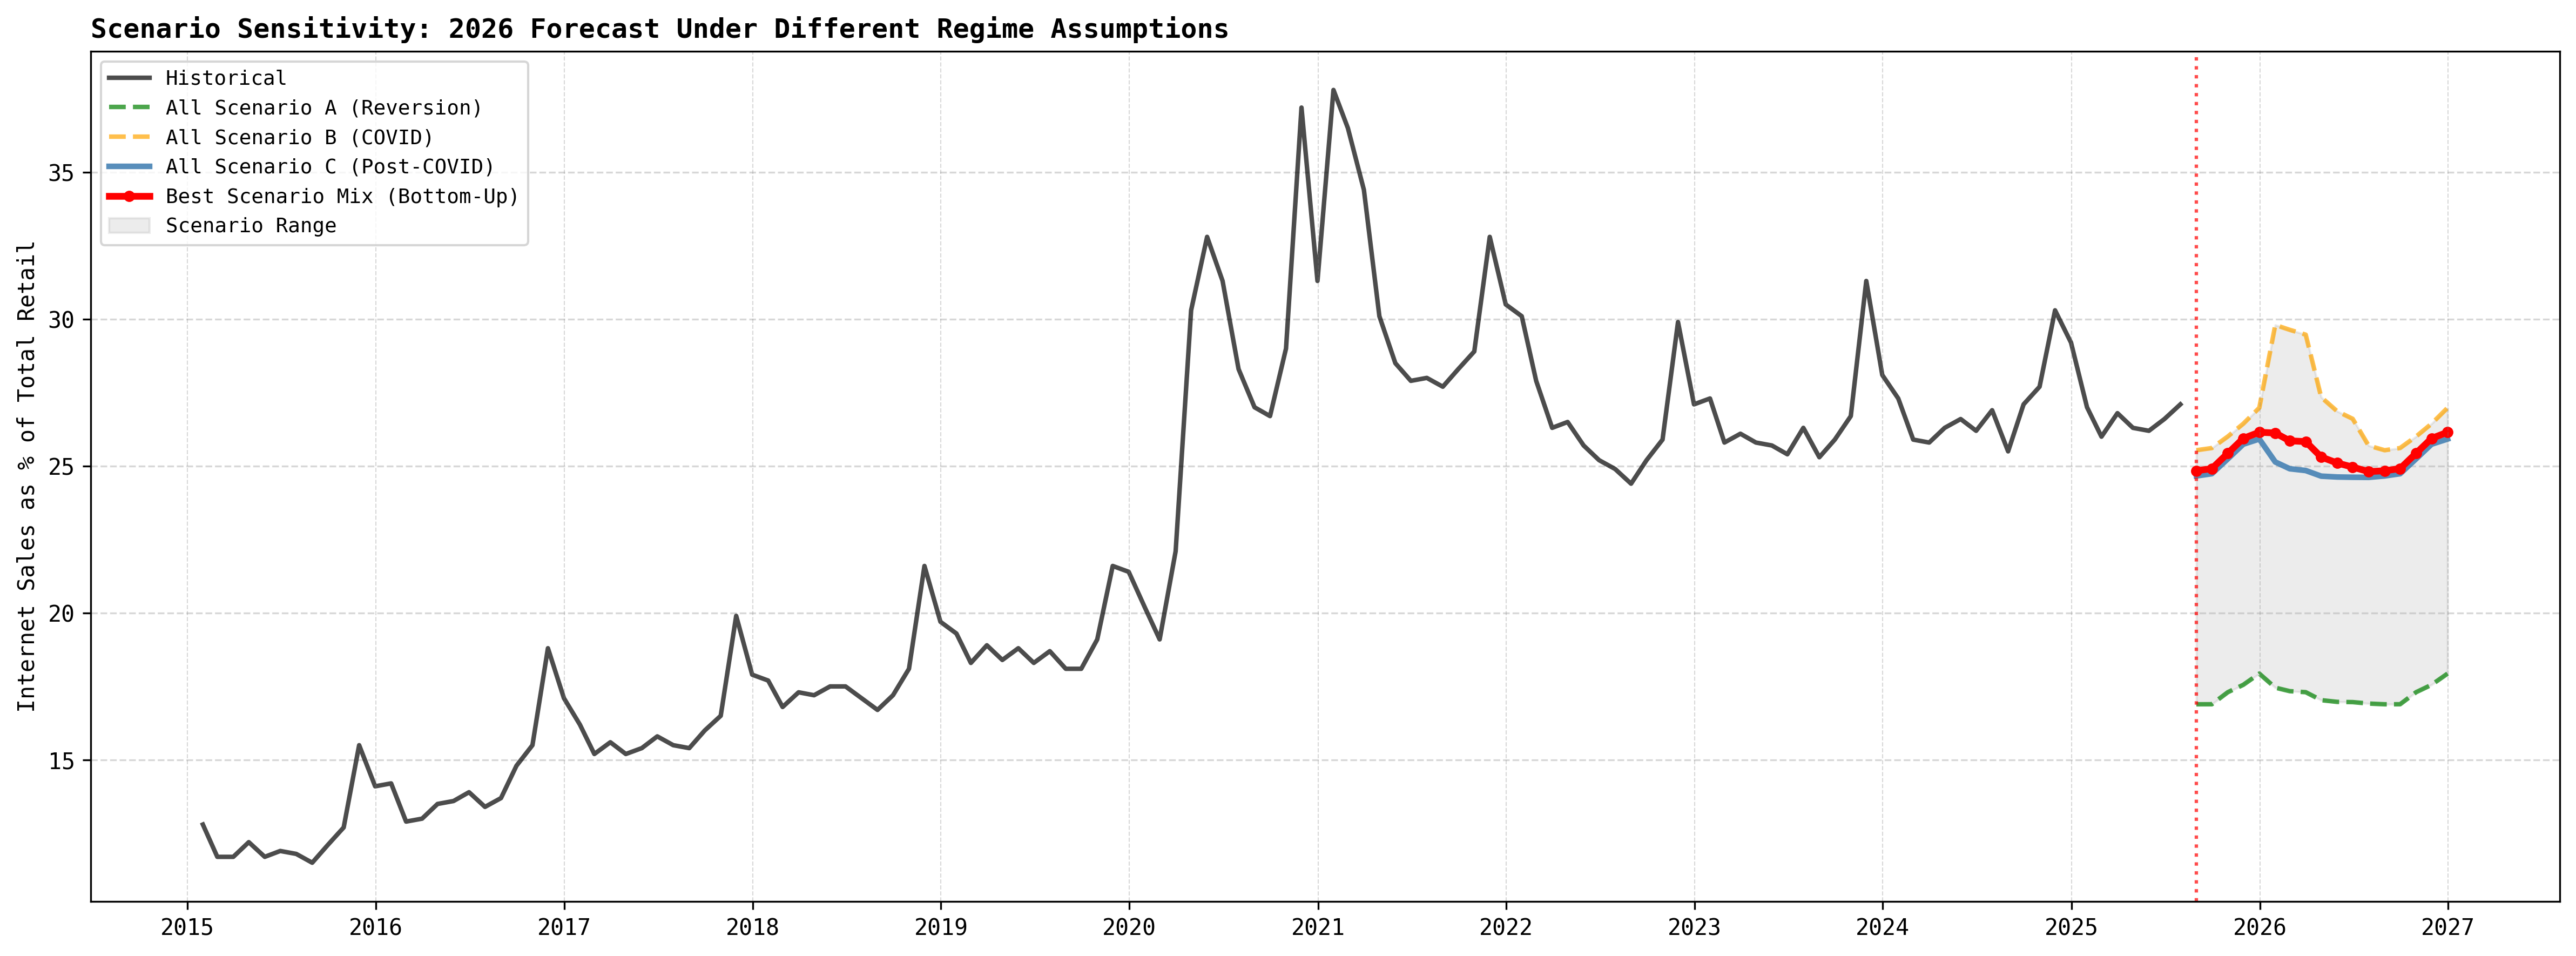

In [21]:
# Plot scenario sensitivity
fig, ax = plt.subplots(figsize=(16, 6), dpi=300)

# Historical
ax.plot(historical.index, historical,
        color='black', linewidth=2, label='Historical', alpha=0.7)

# Three scenarios
ax.plot(scenario_sensitivity['A'].index, scenario_sensitivity['A'],
        color='green', linewidth=2, label='All Scenario A (Reversion)', linestyle='--', alpha=0.7)
ax.plot(scenario_sensitivity['B'].index, scenario_sensitivity['B'],
        color='orange', linewidth=2, label='All Scenario B (COVID)', linestyle='--', alpha=0.7)
ax.plot(scenario_sensitivity['C'].index, scenario_sensitivity['C'],
        color='steelblue', linewidth=2.5, label='All Scenario C (Post-COVID)', alpha=0.9)

# Best-scenario mix (original bottom-up)
ax.plot(aggregate_median.index, aggregate_median,
        color='red', linewidth=3, label='Best Scenario Mix (Bottom-Up)', marker='o', markersize=4)

# Shade scenario range
scenario_min = pd.DataFrame([scenario_sensitivity['A'], scenario_sensitivity['B'], scenario_sensitivity['C']]).min(axis=0)
scenario_max = pd.DataFrame([scenario_sensitivity['A'], scenario_sensitivity['B'], scenario_sensitivity['C']]).max(axis=0)
ax.fill_between(scenario_min.index, scenario_min, scenario_max,
                color='gray', alpha=0.15, label='Scenario Range')

# Formatting
ax.axvline(FORECAST_START, color='red', linestyle=':', linewidth=1.5, alpha=0.7)
time_range = pd.date_range(start='2015-01-01', end='2027-01-01', freq='YS')
ax.set_xticks(time_range)
ax.set_xticklabels([t.year for t in time_range])

for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

ax.legend(loc='upper left', fontsize=9)
ax.set_xlabel('')
ax.set_ylabel('Internet Sales as % of Total Retail')
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_title('Scenario Sensitivity: 2026 Forecast Under Different Regime Assumptions',
             loc='left', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(output_figures_dir / 'scenario_sensitivity_2026.png', bbox_inches='tight', dpi=300)
plt.show()

## 9. Save Results

In [22]:
# Save 2026 forecasts
forecast_2026_data = {
    'bottom_up': {
        'median': aggregate_median,
        'q10': aggregate_q10,
        'q90': aggregate_q90,
        'category_forecasts': df_forecast_medians
    },
    'top_down': {
        'median': topdown_median,
        'q10': topdown_q10,
        'q90': topdown_q90
    },
    'scenario_sensitivity': scenario_sensitivity,
    'best_scenarios': best_scenarios
}

output_path = processed_data_dir / 'forecast_2026.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(forecast_2026_data, f)

print(f"✅ 2026 forecast data saved to {output_path}")

✅ 2026 forecast data saved to /home/mikhailarutyunov/projects/time-series-methods/time-series-methods/data/processed/forecast_2026.pkl


In [23]:
# Save summary table as CSV
summary_table = pd.DataFrame({
    'Month': aggregate_median.index,
    'Bottom_Up_Median': aggregate_median.values,
    'Bottom_Up_Q10': aggregate_q10.values,
    'Bottom_Up_Q90': aggregate_q90.values,
    'Top_Down_Median': topdown_median.values,
    'Top_Down_Q10': topdown_q10.values,
    'Top_Down_Q90': topdown_q90.values,
    'Scenario_A': scenario_sensitivity['A'].values,
    'Scenario_B': scenario_sensitivity['B'].values,
    'Scenario_C': scenario_sensitivity['C'].values
})

summary_table.to_csv(processed_data_dir / 'forecast_2026_summary.csv', index=False)
print(f"✅ Summary table saved to {processed_data_dir / 'forecast_2026_summary.csv'}")

✅ Summary table saved to /home/mikhailarutyunov/projects/time-series-methods/time-series-methods/data/processed/forecast_2026_summary.csv


## 10. Final Summary

In [24]:
print('\n' + '=' * 100)
print('📋 NOTEBOOK 07 COMPLETE: 2026 FORECAST')
print('=' * 100)

print(f'\n🎯 FINAL 2026 FORECAST (Bottom-Up, Volume-Weighted)')
print(f'  December 2026: {aggregate_median.iloc[-1]:.2f}%')
print(f'  80% Confidence Interval: [{aggregate_q10.iloc[-1]:.2f}%, {aggregate_q90.iloc[-1]:.2f}%]')
print(f'  Change from Jul 2025: {aggregate_median.iloc[-1] - historical.iloc[-1]:+.2f} pp')

print(f'\n📊 Bottom-Up vs Top-Down')
print(f'  Bottom-Up (Volume-Weighted): {aggregate_median.iloc[-1]:.2f}%')
print(f'  Top-Down (Aggregate):        {topdown_median.iloc[-1]:.2f}%')
print(f'  Difference:                  {aggregate_median.iloc[-1] - topdown_median.iloc[-1]:+.2f} pp')

print(f'\n🎲 Scenario Sensitivity Range')
print(f'  All Scenario A (Reversion):  {scenario_sensitivity["A"].iloc[-1]:.2f}%')
print(f'  All Scenario B (COVID):      {scenario_sensitivity["B"].iloc[-1]:.2f}%')
print(f'  All Scenario C (Post-COVID): {scenario_sensitivity["C"].iloc[-1]:.2f}%')
print(f'  Range:                       {scenario_range:.2f} pp')

print(f'\n⚖️  Volume Weights Used (based on internet sales £m/week):')
for cat in CATEGORIES:
    print(f'  {cat:25s}: {weights_avg[cat] * 100:5.1f}%')

print(f'\n✅ Key Deliverables:')
print(f'  - Bottom-up 2026 forecast from volume-weighted category aggregation')
print(f'  - Weights based on actual internet sales values from ONS IntValSA')
print(f'  - Top-down comparison using aggregate data')
print(f'  - Scenario sensitivity analysis')
print(f'  - Category contribution breakdown')
print(f'  - Saved to: {output_path}')

print(f'\n🎉 PROJECT COMPLETE!')
print(f'  Phase 1 (Notebooks 01-03): Aggregate analysis with exogenous variables ✅')
print(f'  Phase 2 (Notebooks 04-07): Category-level analysis with regime dummies ✅')


📋 NOTEBOOK 07 COMPLETE: 2026 FORECAST

🎯 FINAL 2026 FORECAST (Bottom-Up, Volume-Weighted)
  December 2026: 26.15%
  80% Confidence Interval: [24.22%, 29.62%]
  Change from Jul 2025: -0.95 pp

📊 Bottom-Up vs Top-Down
  Bottom-Up (Volume-Weighted): 26.15%
  Top-Down (Aggregate):        28.39%
  Difference:                  -2.24 pp

🎲 Scenario Sensitivity Range
  All Scenario A (Reversion):  17.94%
  All Scenario B (COVID):      26.98%
  All Scenario C (Post-COVID): 25.92%
  Range:                       9.05 pp

⚖️  Volume Weights Used (based on internet sales £m/week):
  food_stores              :  43.1%
  clothing_footwear        :  11.7%
  household_goods          :   8.7%
  non_specialised          :   8.7%
  other_stores             :  14.1%
  non_store_retail         :  12.3%

✅ Key Deliverables:
  - Bottom-up 2026 forecast from volume-weighted category aggregation
  - Weights based on actual internet sales values from ONS IntValSA
  - Top-down comparison using aggregate data
  - 